In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision.models import densenet121, resnet18,resnet50
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
from tqdm.notebook import trange, tqdm
from torch.utils.data import Dataset

In [2]:
import os
import copy
import cv2
import random
import numpy as np
import pandas as pd 
import nibabel as nib
from scipy import ndimage
from pathlib import Path
from sklearn import metrics
import random as python_random
import matplotlib.pyplot as plt
import SimpleITK as sitk
from PIL import Image
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, train_test_split

np.random.seed(123)
python_random.seed(123)
# Set the display option to show the full content of each column
pd.set_option('display.max_colwidth', None)

In [3]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "" # this is to handle the error for running model on cpu 
#https://github.com/huggingface/transformers/blob/ad78d9597b224443e9fe65a94acc8c0bc48cd039/docs/source/en/troubleshooting.md?plain=1#L110
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
#Create exp direct and weight 
Exp_dir = Path(r'C:\Users\irams\_IramS\_Iram_MKK\Project_AAPMM\Deep_learning\Experiments\Exp_1')
if not os.path.exists(Exp_dir):
    os.mkdir(Exp_dir)


weights_path = os.path.join(Exp_dir,"Weights")
if not os.path.exists(weights_path):
    os.mkdir(weights_path)

In [5]:
# only plotting function to see if transformed tensors are correct

def plot_image_from_tensor(tensor, transformation=None):
    # Apply the transformation if provided
    transformed_tensor = tensor if transformation is None else transformation(tensor)
    
    # Convert the tensor to a NumPy array
    image_np = transformed_tensor.permute(1, 2, 0).numpy()  # Assuming CHW format
    
    # Plot the image
    plt.imshow(image_np, cmap='gray')
    plt.axis('off')
    plt.show()

In [6]:
import torch.nn.functional as F
class DenseNetClassifier(nn.Module):
    def __init__(self, num_classes=1, dropout_prob=0.4):
        super(DenseNetClassifier, self).__init__()
        
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(1, 3, kernel_size=7, stride=1, padding=1)
        
        # Load pre-trained DenseNet model without classifier
        self.densenet = densenet121(pretrained=False)
        del self.densenet.classifier  # Remove existing classifier
        
        # Define the custom classifier
        self.classifier = nn.Sequential(
            #nn.Dropout(dropout_prob),
            nn.Linear(in_features=1024, out_features=num_classes)
        )

    def forward(self, x):
        # Forward pass through the first convolutional layer
        x = self.conv1(x)
        # Forward pass through the DenseNet feature extractor
        
        x = self.densenet.features(x)
        
        #x = F.relu(x, inplace=True)
        
        x = F.adaptive_avg_pool2d(x, (1, 1))
        
        x = torch.flatten(x, 1)
       
        # Forward pass through the custom classifier
        x = self.classifier(x)
        
        # Apply sigmoid activation for binary classification
        x = torch.sigmoid(x)
        
        return x
#https://www.kaggle.com/code/arnoldyanga/image-classification-using-pytorch
# for building better classifier

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=1, dropout_prob=0.4):
        super(ResNetClassifier, self).__init__()
        
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(1, 3, kernel_size=7, stride=1, padding=1)
        
        # Load pre-trained ResNet18 model without classifier
        self.resnet = resnet18(pretrained=False)
        self.resnet.fc = nn.Identity()  # Remove existing fully connected layer
        
        # Define the custom classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=512, out_features=num_classes)
        )

    def forward(self, x):
        
        x = self.conv1(x)
        
        # Forward pass through the ResNet feature extractor
        x = self.resnet(x)
        
        x = torch.flatten(x, 1)
        
        # Forward pass through the custom classifier
        x = self.classifier(x)
        
        # Apply sigmoid activation for binary classification
        x = torch.sigmoid(x)
        
        return x


In [8]:

# initialized device as 'cuda' if available, else 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
cnn_model = DenseNetClassifier(num_classes=1, dropout_prob=0.4).to(device)


C:\Users\irams\anaconda3\envs\pytorchenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\irams\anaconda3\envs\pytorchenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
"""
# initialized device as 'cuda' if available, else 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
cnn_model = ResNetClassifier(num_classes=1, dropout_prob=0.4).to(device)
"""

"\n# initialized device as 'cuda' if available, else 'cpu'\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n# Train the model\ncnn_model = ResNetClassifier(num_classes=1, dropout_prob=0.4).to(device)\n"

In [10]:
class CustomNormalize(object):
    def __call__(self, img):
        # Check if input is a NumPy array or a PyTorch tensor
        if isinstance(img, np.ndarray):
            level = 40
            window = 400
            max_val = level + window / 2
            min_val = level - window / 2
            img = np.clip(img, min_val, max_val)
            img = (img - min_val) / (max_val - min_val)
            img= img.astype("float32")
        elif torch.is_tensor(img):
            level = 40
            window = 400
            max_val = level + window / 2
            min_val = level - window / 2
            img = torch.clamp(img, min_val, max_val)
            img = (img - min_val) / (max_val - min_val)
            img= img.float()
        else:
            raise TypeError("Unsupported input type. Input must be a NumPy array or a PyTorch tensor.")
        return img

class CustomResize(object):
    def __call__(self, img):
        # Check if input is a NumPy array or a PyTorch tensor
        if isinstance(img, np.ndarray):
            # Set the desired dimensions
            desired_width = 224
            desired_height = 224
            # Resize the image
            resized_img = cv2.resize(img, (desired_width, desired_height))
        elif torch.is_tensor(img):
            # Set the desired dimensions
            desired_width = 224
            desired_height = 224
            # Resize the image
            resized_img = torch.nn.functional.interpolate(
                img.unsqueeze(0),  # Add batch and channel dimensions
                size=(desired_height, desired_width),  # Desired size
                mode='bilinear',  # Interpolation mode
                align_corners=False
            ).squeeze(0)  # Remove batch and channel dimensions
        else:
            raise TypeError("Unsupported input type. Input must be a NumPy array or a PyTorch tensor.")
        return resized_img

In [11]:
from PIL import Image

class CustomNormalize(object):
    def __call__(self, img):
        # Check if input is a NumPy array, PIL image, or a PyTorch tensor
        if isinstance(img, np.ndarray):
            level = 40
            window = 400
            max_val = level + window / 2
            min_val = level - window / 2
            img = np.clip(img, min_val, max_val)
            img = (img - min_val) / (max_val - min_val)
            img = img.astype("float32")
        elif isinstance(img, Image.Image):  # Check if input is a PIL image
            # Convert PIL image to NumPy array
            img = np.array(img)
            level = 40
            window = 400
            max_val = level + window / 2
            min_val = level - window / 2
            img = np.clip(img, min_val, max_val)
            img = (img - min_val) / (max_val - min_val)
            img = img.astype("float32")
        elif torch.is_tensor(img):
            level = 40
            window = 400
            max_val = level + window / 2
            min_val = level - window / 2
            img = torch.clamp(img, min_val, max_val)
            img = (img - min_val) / (max_val - min_val)
            img = img.float()
        else:
            raise TypeError("Unsupported input type. Input must be a NumPy array, PIL image, or a PyTorch tensor.")
        return img

class CustomResize(object):
    def __call__(self, img):
        # Check if input is a NumPy array, PIL image, or a PyTorch tensor
        if isinstance(img, np.ndarray):
            # Set the desired dimensions
            desired_width = 224
            desired_height = 224
            # Resize the image
            resized_img = cv2.resize(img, (desired_width, desired_height))
        elif isinstance(img, Image.Image):  # Check if input is a PIL image
            # Resize the PIL image
            desired_width = 224
            desired_height = 224
            resized_img = img.resize((desired_width, desired_height), Image.BILINEAR)
        elif torch.is_tensor(img):
            # Set the desired dimensions
            desired_width = 224
            desired_height = 224
            # Resize the tensor
            resized_img = torch.nn.functional.interpolate(
                img.unsqueeze(0),  # Add batch and channel dimensions
                size=(desired_height, desired_width),  # Desired size
                mode='bilinear',  # Interpolation mode
                align_corners=False
            ).squeeze(0)  # Remove batch and channel dimensions
        else:
            raise TypeError("Unsupported input type. Input must be a NumPy array, PIL image, or a PyTorch tensor.")
        return resized_img


In [12]:
# Define the transforms.Compose sequence
initial_transform = transforms.Compose([
    transforms.ToTensor()  # Convert image to PyTorch tensor
])

In [13]:
class pytorch_data(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        nifti_path = self.data_df.iloc[idx]['Paths']
        nifti_img = sitk.ReadImage(nifti_path)  # Read file using SimpleITK
        image_array = sitk.GetArrayFromImage(nifti_img)  # Convert to numpy array

        # Convert numpy array to PIL Image
        PIL_image = Image.fromarray(image_array)

        label = self.data_df.iloc[idx]['Labels']
        #subject_id = self.data_df.iloc[idx]['subject_id']
        
        if self.transform:
            image = self.transform(PIL_image)
            
        return image, label 

        #return image, label, subject_id


In [14]:
def create_dataloader(dataset, batch_size, is_training):
    """
    Create a DataLoader for the given dataset.
    
    Args:
    - dataset: The dataset to create DataLoader from.
    - batch_size: Batch size for DataLoader.
    - is_training: Boolean flag indicating whether it's for training or validation.
    
    Returns:
    - dataloader: The created DataLoader.
    """
    # Choose shuffle option based on whether it's for training or validation
    shuffle = is_training
    
    # Create DataLoader
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=shuffle)
    
    return dataloader

In [15]:
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        # Convert the input to a NumPy array if it's a tensor
        if torch.is_tensor(tensor):
            array = tensor.numpy()
        elif isinstance(tensor, np.ndarray):
            array = tensor
        else:
            raise TypeError("Unsupported input type. Input must be a NumPy array or a PyTorch tensor.")
        
        # Add Gaussian noise
        noise = np.random.normal(self.mean, self.std, size=array.shape)
        noisy_array = array + noise
        # Clip the values to ensure they are within the valid range [0, 1]
        noisy_array = np.clip(noisy_array, 0, 1)
        
        # Convert the noisy array back to a tensor if the input was a tensor
        if torch.is_tensor(tensor):
            noisy_tensor = torch.from_numpy(noisy_array)
            return noisy_tensor
        else:
            return noisy_array


class RandomGamma(object):
    def __init__(self, gamma_range=(0.5, 2), gain=1):
        self.gamma_range = gamma_range
        self.gain = gain

    def __call__(self, img):
        gamma = random.uniform(self.gamma_range[0], self.gamma_range[1])
        return transforms.functional.adjust_gamma(img, gamma, gain=self.gain)

In [16]:
tr_transf = transforms.Compose([
        CustomNormalize(),  # Apply custom normalization
        CustomResize(),
        #transforms.RandomApply([transforms.RandomRotation(degrees=10)], p=0.2),
        #transforms.RandomApply([transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(1.0, 1.0))], p=0.8),
        #transforms.RandomApply([AddGaussianNoise(mean=0, std=np.random.uniform(0, 0.05))], p=0.5),
        #transforms.RandomApply([RandomGamma(gamma_range=(0.5, 2))], p=0.2),
        #transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.5, 1.5))], p=0.2),
        transforms.ToTensor(),
    ])

    # For the validation dataset, we don't need any augmentation; simply convert images into tensors
val_transf = transforms.Compose([
        CustomNormalize(),  # Apply custom normalization
        CustomResize(),
        transforms.ToTensor(),
    ])

In [17]:
# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target) # get loss
    metric_b = (output.round() == target).float().mean()
    
    if opt is not None:

        # backward pass
        opt.zero_grad()
        loss.backward()
        # update weigths
        opt.step()

    return loss.item(), metric_b.item()

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl)
  
    # internal loop over dataset
    for i, (xb, yb) in enumerate(dataset_dl):
        # move batch to device

        xb=xb.to(device)
        
        yb=yb.to(device)
        
        
        yb=yb.view(-1, 1).float() # reshaping labels to match output of BCE loss function
        
        output=model(xb) # get model output on batch of the data 
        
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt=None) # get loss per batch
        
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric


In [18]:
def train_val(model, params, verbose=True):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["loss_func"]
    opt=params["optimiser"]
    train_dl=params["train_loader"]
    val_dl=params["val_loader"]
    weights_path=params["weights_path"]
    
    loss_history={"train_loss": [],"val_loss": []} # history of loss values in each epoch
    metric_history={"train_acc": [],"val_acc": []} # histroy of metric values in each epoch
    
    best_model_wts = copy.deepcopy(model.state_dict()) # a deep copy of weights for the best performing model
    best_loss=float('inf') # initialize best loss to a large value
    
    ''' Train Model n_epochs '''
    
    for epoch in tqdm(range(epochs)):
        
        '''
        Train Model Process
        '''
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train_loss"].append(train_loss)
        metric_history["train_acc"].append(train_metric)
        
        '''
        
        Evaluate Model Process
        
        '''
        
        model.eval()
        with torch.no_grad():

            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best model
        if(val_loss < best_loss):
            print('validation loss is less than best loss')
            best_loss = val_loss
            
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            weights_filename = f'weights.pt'
            torch.save(model.state_dict(), os.path.join(weights_path,weights_filename))  
            if(verbose):
                print("Saved best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val_loss"].append(val_loss)
        metric_history["val_acc"].append(val_metric)

            
        print(f"Epoch:{epoch + 1} / {epochs},"
                  f"train loss:{train_loss:.5f}, train acc: {train_metric:.5f}, "
                  f"valid loss:{val_loss:.5f}, valid acc:{val_metric:.5f}")
        print("-" * 100) 


    # load best weights to final model
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [19]:
# Define paths for negative and positive directories
sgmd_neg = Path(r"C:\Users\irams\_IramS\_Iram_MKK\Project_AAPMM\Deep_learning\Data\Test_2\normal")
sgmd_pos = Path(r"C:\Users\irams\_IramS\_Iram_MKK\Project_AAPMM\Deep_learning\Data\Test_2\sigmoid")

In [20]:
# List files in negative and positive directories
sgmd_neg_paths = []
for root, dirs, files in os.walk(sgmd_neg):
    for dir in dirs:
        nifti_2d_folder = os.path.join(root, dir, 'Patch_2D')
        if os.path.isdir(nifti_2d_folder):
            for file in sorted(os.listdir(nifti_2d_folder), key=lambda x: os.path.getmtime(os.path.join(nifti_2d_folder, x))):
                if file.endswith(".nii"):
                    sgmd_neg_paths.append(os.path.join(nifti_2d_folder, file))

sgmd_pos_paths = []
for root, dirs, files in os.walk(sgmd_pos):
    for dir in dirs:
        nifti_2d_folder = os.path.join(root, dir, 'Patch_2D')
        if os.path.isdir(nifti_2d_folder):
            for file in sorted(os.listdir(nifti_2d_folder), key=lambda x: os.path.getmtime(os.path.join(nifti_2d_folder, x))):
                if file.endswith(".nii"):
                    sgmd_pos_paths.append(os.path.join(nifti_2d_folder, file))

In [21]:
# Create labels
sgmd_neg_labels = [0] * len(sgmd_neg_paths)
sgmd_pos_labels = [1] * len(sgmd_pos_paths)

# Concatenate labels
labels = pd.DataFrame({'Labels': sgmd_neg_labels + sgmd_pos_labels})

# Extract subject IDs or file paths
subject_ids = [path.split('Patch_2D')[0].split(os.path.sep)[-2] for path in sgmd_neg_paths + sgmd_pos_paths]


# Create DataFrame with subject IDs , labels and path to all images of each subject
data_set = pd.DataFrame({'subject_id': subject_ids, 'Labels': labels['Labels'], 'Paths': sgmd_neg_paths + sgmd_pos_paths})

In [22]:
# Drop duplicates based on subject_id, this dataframe can be then used for stratified splitting based on uniques 
# subject ids
data_subject = data_set.drop_duplicates(subset=['subject_id'])

# Drop the 'Paths' column
data_subject = data_subject.drop(columns=['Paths'])

In [23]:
# Perform stratified splitting
# full indicates entire training data that will be further spilt into train and validation in next step
X_train, X_valid, y_train, y_valid = train_test_split(data_subject['subject_id'], data_subject['Labels'], test_size=0.2, stratify=data_subject['Labels'], random_state=42)

# Create dataframes for train and test sets
train_df = pd.DataFrame({'subject_id': X_train, 'Labels': y_train})
valid_df = pd.DataFrame({'subject_id': X_valid, 'Labels': y_valid})

# Calculate class distribution in train and test sets
train_class_distribution_full = train_df['Labels'].value_counts(normalize=True)
valid_class_distribution = valid_df['Labels'].value_counts(normalize=True)

# Print class distribution
#print("Train class distribution:")
#print(train_class_distribution_full)
#print("\nValid class distribution:")
#print(valid_class_distribution)


In [24]:
# Filter rows from dataset where subject_id matches those in X_train and X_val
X_train_ = data_set[data_set['subject_id'].isin(train_df['subject_id'])]
X_val_ = data_set[data_set['subject_id'].isin(valid_df['subject_id'])]
    
# Reste indexes
X_train_.reset_index(drop=True, inplace=True)
X_val_.reset_index(drop=True, inplace=True)
    
# Create an instance of the custom dataset
train_dataset = pytorch_data(data_df=X_train_, transform=initial_transform)
val_dataset = pytorch_data(data_df=X_val_, transform=initial_transform)
    
# Apply augmentation 
train_dataset.transform = tr_transf
val_dataset.transform = val_transf
    
    #original_image, label = train_dataset[15]
    #print(original_image.shape)
    # Plot the original image
    #plot_image_from_tensor(original_image)
    
train_dl = create_dataloader(train_dataset, batch_size=32, is_training=True)
val_dl = create_dataloader(val_dataset, batch_size=32, is_training=False)
    


In [25]:
params_train = {
        "train_loader": train_dl,
        "val_loader": val_dl,
        "epochs": 30,
        "optimiser":optim.Adam(cnn_model.parameters(), lr=2e-3, weight_decay=0.09),
        "loss_func": nn.BCEWithLogitsLoss(),
        "weights_path": weights_path,
}
    
''' Actual Train / Evaluation of CNN Model '''
# train and validate the model
cnn_model, loss_history, metric_history = train_val(cnn_model, params_train, verbose=True)

  0%|          | 0/30 [00:00<?, ?it/s]

validation loss is less than best loss
Saved best model weights!
Epoch:1 / 30,train loss:0.67338, train acc: 0.70602, valid loss:0.67954, valid acc:0.59375
----------------------------------------------------------------------------------------------------
validation loss is less than best loss
Saved best model weights!
Epoch:2 / 30,train loss:0.67424, train acc: 0.70516, valid loss:0.67808, valid acc:0.55208
----------------------------------------------------------------------------------------------------
validation loss is less than best loss
Saved best model weights!
Epoch:3 / 30,train loss:0.67412, train acc: 0.71633, valid loss:0.67456, valid acc:0.57292
----------------------------------------------------------------------------------------------------
validation loss is less than best loss
Saved best model weights!
Epoch:4 / 30,train loss:0.67564, train acc: 0.71602, valid loss:0.67400, valid acc:0.55729
-------------------------------------------------------------------------

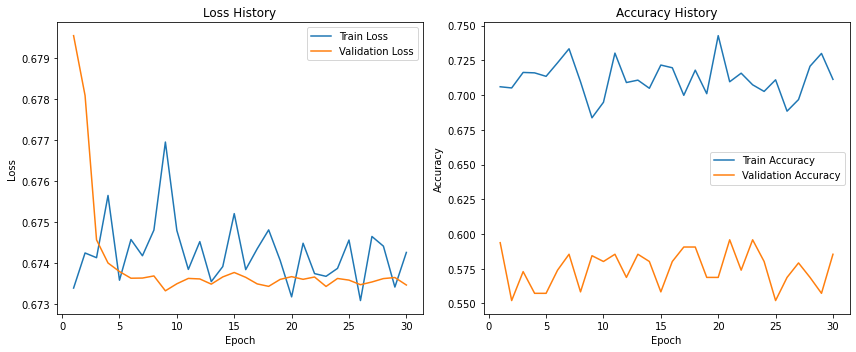

In [26]:
import seaborn as sns

# Number of epochs
epochs = params_train["epochs"]

# Initialize subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss
sns.lineplot(x=[*range(1, epochs + 1)], y=loss_history["train_loss"], ax=ax[0], label='Train Loss')
sns.lineplot(x=[*range(1, epochs + 1)], y=loss_history["val_loss"], ax=ax[0], label='Validation Loss')

# Plot training and validation accuracy
sns.lineplot(x=[*range(1, epochs + 1)], y=metric_history["train_acc"], ax=ax[1], label='Train Accuracy')
sns.lineplot(x=[*range(1, epochs + 1)], y=metric_history["val_acc"], ax=ax[1], label='Validation Accuracy')

# Set titles and labels
ax[0].set_title(f'Loss History')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].set_title(f'Accuracy History')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show plot
plt.tight_layout()
plt.show()
